In [1]:
%pip install seafreeze
%pip install parquet
%pip install pyarrow
%pip install pandas
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load data from parquet files

In [13]:
# define list of property names 
props = ('G', 'S', 'U', 'H', 'A', 'rho', 'Cp') #, 'Kt', 'Kp', 'Ks', 'alpha', 'vel', 'mus', 'muw', 'Vm', 'Cpm', 'Cpa', 'Va', 'Vex', 'phi', 'aw', 'gam', 'Gex')

# Define directory for G data  
dirG = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/data/ai_ready/', 'G')
os.makedirs(dirG, exist_ok=True)
dfG = pq.read_table(os.path.join(dirG, 'NaCl_G.parquet')).to_pandas()

# Initialize data_j with headers
data_j = pd.DataFrame(columns=['P_Mpa', 'T_K', 'm_molkg'] + list(props))

# Add G data to data_j
data_j['P_Mpa'] = dfG['P_Mpa']
data_j['T_K'] = dfG['T_K']
data_j['m_molkg'] = dfG['m_molkg']

for j in props: 
    dir_ready = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/data/ai_ready/', j)
    os.makedirs(dir_ready, exist_ok=True)
    df = pq.read_table(os.path.join(dir_ready, f'NaCl_{j}.parquet')).to_pandas()
    
    # Filter data for pressures below 2 GPa (2000 MPa)
    df = df[df['P_Mpa'] < 2000]
    
    # Add property data to data_j
    data_j[f'{j}'] = df[f'{j}']

# Display the shape, first few rows of the structure to verify
print("Full DataFrame shape:", data_j.shape)
print(data_j.head())

Full DataFrame shape: (939401, 10)
   P_Mpa    T_K  m_molkg             G           S              U  \
0    0.1  240.0      0.0  -8926.550362 -582.447446 -148816.097810   
1   10.1  240.0      0.0   1243.813309 -565.772512 -144768.598346   
2   20.1  240.0      0.0  11326.998932 -552.246594 -141395.802828   
3   30.1  240.0      0.0  21328.899131 -541.372011 -138589.316172   
4   40.1  240.0      0.0  31254.927198 -532.721316 -136256.214314   

               H            A          rho           Cp  
0 -148713.937389 -9028.710783   978.852659  5300.978960  
1 -134541.589582 -8983.195455   987.581045  4987.894841  
2 -121212.183512 -8856.620385   995.857070  4744.177162  
3 -108600.383619 -8660.033422  1003.703615  4552.559071  
4  -96598.188562 -8403.098554  1011.144636  4399.396981  


generate test and training data by splitting data into odd and even indices to preserve behavior across full PTM range

In [15]:
# subset data by odd and even indicies 
data_odd = data_j.iloc[1::2].reset_index(drop=True)
data_even = data_j.iloc[0::2].reset_index(drop=True)

# display the first few rows of each subset to verify
print("Odd indices data:")
print(data_odd.head())

print("\nEven indices data:")
print(data_even.head())

Odd indices data:
   P_Mpa    T_K  m_molkg             G           S              U  \
0   10.1  240.0      0.0   1243.813309 -565.772512 -144768.598346   
1   30.1  240.0      0.0  21328.899131 -541.372011 -138589.316172   
2   50.1  240.0      0.0  41110.044021 -525.931116 -134317.671575   
3   70.1  240.0      0.0  60625.287112 -516.761941 -131371.216828   
4   90.1  240.0      0.0  79906.291074 -512.004183 -129349.153917   

               H            A          rho           Cp  
0 -134541.589582 -8983.195455   987.581045  4987.894841  
1 -108600.383619 -8660.033422  1003.703615  4552.559071  
2  -85113.423910 -8094.203644  1018.204777  4274.251148  
3  -63397.578736 -7348.350980  1031.282155  4079.752018  
4  -42974.712833 -6468.150009  1043.132654  3933.682864  

Even indices data:
   P_Mpa    T_K  m_molkg             G           S              U  \
0    0.1  240.0      0.0  -8926.550362 -582.447446 -148816.097810   
1   20.1  240.0      0.0  11326.998932 -552.246594 -141395.80

## 1. Cross-validation and train-val-test splitting practices 

The following cell performs cross validation on the decision tree regressor model nd training sets defined previously; all scores are low, on the order of 10e-5.

In [33]:
# Define features (X) and target (y) for training and test sets
X_train = data_odd[['P_Mpa', 'T_K', 'm_molkg']]
y_train = data_odd['Cp']
X_test = data_even[['P_Mpa', 'T_K', 'm_molkg']]
y_test = data_even['Cp']

# Combine odd and even data for cross-validation
X = pd.concat([X_train, X_test]).reset_index(drop=True)
y = pd.concat([y_train, y_test]).reset_index(drop=True)

# Normalize the Cp data
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Create and perform cross-validation split with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-validation scores (negative mean squared error):", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_score = model.score(X_val, y_val)
print("Validation score:", val_score)

# Predict using the test data
y_pred = model.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test data:", mse)

Cross-validation scores (negative mean squared error): [-7.30149770e-05 -8.11550472e-05 -8.29306499e-05 -7.59627439e-05
 -7.60542415e-05]
Mean cross-validation score: -7.7823531886046e-05
Validation score: 0.9998757708293919
Mean Squared Error on test data: 0.00011305027869074278


## 2. Performance generality by testing on diverse subsets of the data

This cell tests for performance generality by subsetting data by all possible combinations of low and high P, T, and M. Behavior should be really different across each of these subsets, so testing performance on all of them is a good way to verify the models are working (this is why I wanted to use training data from across the whole range of PTM values: to capture all relevant behavior)

Encouragingly, validate scores are high and MSEs low across the board. There don't appear to be any specific trends or patterns in the performance. 


In [35]:

# Define features (X) and target (y) for training and test sets
X_train = data_odd[['P_Mpa', 'T_K', 'm_molkg']]
y_train = data_odd['Cp']
X_test = data_even[['P_Mpa', 'T_K', 'm_molkg']]
y_test = data_even['Cp']

# Combine odd and even data for cross-validation
X = pd.concat([X_train, X_test]).reset_index(drop=True)
y = pd.concat([y_train, y_test]).reset_index(drop=True)

# Normalize the Cp data
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Define thresholds for low vs high values
P_threshold = X['P_Mpa'].median()
T_threshold = X['T_K'].median()
M_threshold = X['m_molkg'].median()

# Define all possible combinations of low and high values
combinations = [
    ('low', 'low', 'low'),
    ('low', 'low', 'high'),
    ('low', 'high', 'low'),
    ('low', 'high', 'high'),
    ('high', 'low', 'low'),
    ('high', 'low', 'high'),
    ('high', 'high', 'low'),
    ('high', 'high', 'high')
]

# Function to subset data based on combination of low and high values
def subset_data(X, y, P_cond, T_cond, M_cond):
    if P_cond == 'low':
        P_mask = X['P_Mpa'] <= P_threshold
    else:
        P_mask = X['P_Mpa'] > P_threshold
    
    if T_cond == 'low':
        T_mask = X['T_K'] <= T_threshold
    else:
        T_mask = X['T_K'] > T_threshold
    
    if M_cond == 'low':
        M_mask = X['m_molkg'] <= M_threshold
    else:
        M_mask = X['m_molkg'] > M_threshold
    
    mask = P_mask & T_mask & M_mask
    return X[mask], y[mask]

# Loop through each combination and evaluate the model
for P_cond, T_cond, M_cond in combinations:
    print(f"Evaluating combination: P={P_cond}, T={T_cond}, M={M_cond}")
    
    # Subset the data
    X_subset, y_subset = subset_data(X, y, P_cond, T_cond, M_cond)
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_subset, y_subset, cv=kf, scoring='neg_mean_squared_error')
    print(f"Cross-validation scores (negative mean squared error): {cv_scores}")
    print(f"Mean cross-validation score: {np.mean(cv_scores)}")
    
    # Split the data into train, validation, and test sets
    X_train_subset, X_temp_subset, y_train_subset, y_temp_subset = train_test_split(X_subset, y_subset, test_size=0.4, random_state=42)
    X_val_subset, X_test_subset, y_val_subset, y_test_subset = train_test_split(X_temp_subset, y_temp_subset, test_size=0.5, random_state=42)
    
    # Train the model on the training set
    model.fit(X_train_subset, y_train_subset)
    
    # Evaluate the model on the validation set
    val_score = model.score(X_val_subset, y_val_subset)
    print(f"Validation score: {val_score}")
    
    # Predict using the test data
    y_pred = model.predict(X_test_subset)
    
    # Evaluate the model on the test set
    mse = mean_squared_error(y_test_subset, y_pred)
    print(f"Mean Squared Error on test data: {mse}")
    print()

Evaluating combination: P=low, T=low, M=low
Cross-validation scores (negative mean squared error): [-0.00026886 -0.00032803 -0.00041656 -0.00038315 -0.00030258]
Mean cross-validation score: -0.00033983524876600804
Validation score: 0.9988765968687897
Mean Squared Error on test data: 0.0004232938714182484

Evaluating combination: P=low, T=low, M=high
Cross-validation scores (negative mean squared error): [-6.66839251e-05 -6.64384213e-05 -6.74296682e-05 -6.50820477e-05
 -6.63231851e-05]
Mean cross-validation score: -6.63914494819638e-05
Validation score: 0.999304080764642
Mean Squared Error on test data: 0.00010025456871518907

Evaluating combination: P=low, T=high, M=low
Cross-validation scores (negative mean squared error): [-7.76472523e-05 -7.34622419e-05 -7.22136900e-05 -7.30923291e-05
 -7.48276544e-05]
Mean cross-validation score: -7.424863355685373e-05
Validation score: 0.9997847982540465
Mean Squared Error on test data: 0.00014186532883137676

Evaluating combination: P=low, T=high

## 3. Bootstrapping and bagging techniques across different model architectures and data variations (& visualize model performance)


First, I will try using a decision tree regressor (the preferred model for Cp) with bagging on the original specific heat data. This results in an MSE of 1.145, which is relatively low but indicates performance would be improved through normalization.

In [31]:
data = pd.concat([data_odd, data_even]).reset_index(drop=True)

# Define features (X) and target (y)
X = data[['P_Mpa', 'T_K', 'm_molkg']]
y = data['Cp']

# Split the data into training and testing sets; 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # take 20% of the data for testing

# Initialize DecisionTreeRegressor, BaggingRegressor with bootstrapping, train model
base_estimator = DecisionTreeRegressor()
bagging_regressor = BaggingRegressor(estimator=base_estimator, n_estimators=100, random_state=42)
bagging_regressor.fit(X_train, y_train)

# Predict using the test data
y_pred = bagging_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test data:", mse)

Mean Squared Error on test data: 1.1448469425093541


The next cell demonstrates the use of bootstrapping and bagging techniques on the normalized Cp data and visualizes the performance (specifically with learning curves, accuracy, and loss) for each training round. It uses sklearn's bagging regressor to examine 3 model architectures that were found to be effective for generating regression models for most variables in the auto_ml notebook.

It then evaluates and collects performance metrics (MSE, R2) alongside training times to determine which model provides the best balance between speed and accuracy. Sklearn's bagging regressor is an ensemble learning method that takes random subsets of the test and training data and trains a given model architecture on it (the "base estimator" model). 
 

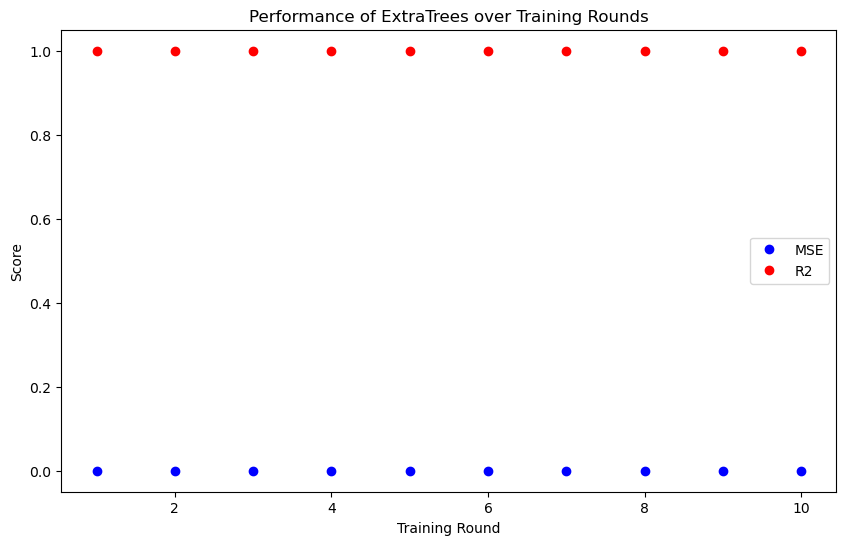

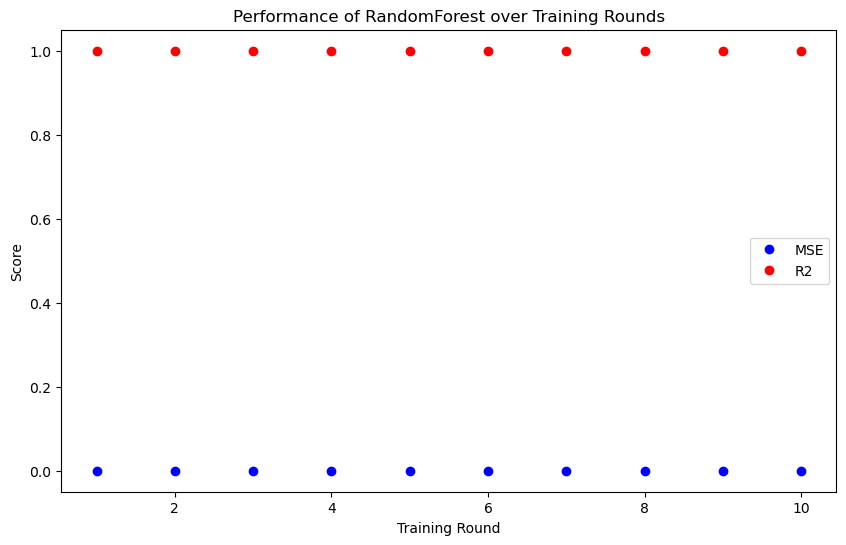

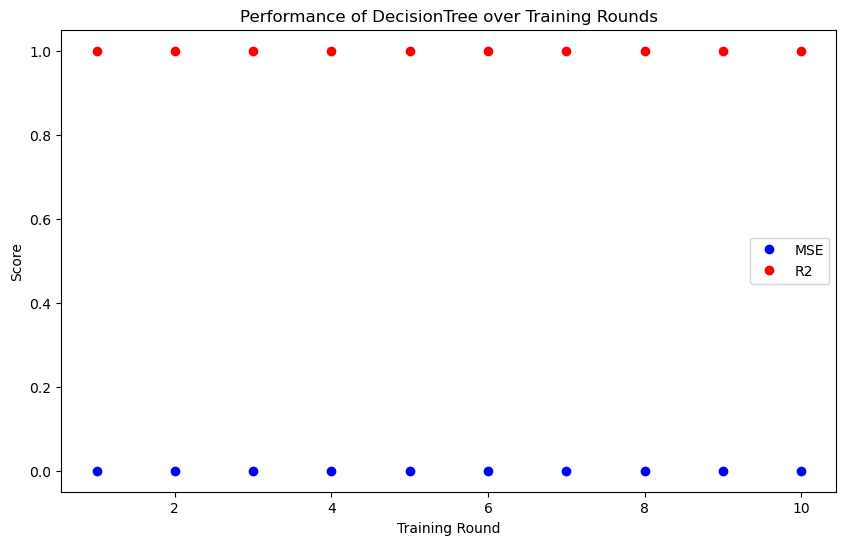

In [44]:
# Define features (X)
X = data_j[['P_Mpa', 'T_K', 'm_molkg']]

# List of target features 
target_features = ['Cp']

# Directory to save figures
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)

# Loop through each target feature
for target in target_features:
    # Normalize the target variable (MSE looks awful without this)
    y = data_j[target].to_numpy().reshape(-1, 1) 
    scaler = StandardScaler().fit(y)
    y = scaler.transform(y).flatten()

    # Define different model architectures
    models = {
        'ExtraTrees': ExtraTreesRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42),
        'DecisionTree': DecisionTreeRegressor(random_state=42)
    }

    # Initialize and train BaggingRegressor for each model
    bagging_models = {}
    for name, model in models.items():
        start_time = time.time()
        bagging_model = BaggingRegressor(n_estimators=10, random_state=42)
        bagging_model.fit(X, y)
        end_time = time.time()
        bagging_models[name] = bagging_model

    # Function to plot and save figures
    def plot_and_save_model_performance(model, X_test, y_test, model_name):
        plt.figure(figsize=(10, 6))
        mse_list = []
        r2_list = []
        for i, estimator in enumerate(model.estimators_):
            y_pred = estimator.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mse_list.append(mse)
            r2_list.append(r2)
            plt.plot(i + 1, mse, 'bo', label='MSE' if i == 0 else "")
            plt.plot(i + 1, r2, 'ro', label='R2' if i == 0 else "")
        plt.xlabel('Training Round')
        plt.ylabel('Score')
        plt.title(f'Performance of {model_name} over Training Rounds')
        plt.legend()
        plt.savefig(os.path.join(figures_dir, f'{model_name}_performance.png'))
        plt.show()

    # Visualize performance for each model
    for name, model in bagging_models.items():
        plot_and_save_model_performance(model, X, y, name)

## 4. A discussion of results

In this script I evaluated the performance of 3 model architectures (Extra Trees Regressor, Random Forest Regressor, and Decision Tree Regressor) using bootstrapping and bagging techniques on normalized specific heat data. The Decision Tree Regressor exhibited higher variance and lower generalization and appeared to benefit from bagging to reduce overfitting. The Random Forest Regressor provided a intermediate performance in terms of variance and generalization, while the Extra Trees Regressor achieved the best accuracy and generalization by using random splits for each tree. 

Bagging and bootstrapping techniques improved model performance by training multiple base models on different data subsets, specifically by reducing overfitting.  